### Simulations for the mean

In [3]:
import scanpy as sc

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import scipy.sparse as sparse
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/Users/mincheolkim/opt/miniconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [5]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'xx-small',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)


In [6]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/')
import memento
import memento.simulate as simulate

In [7]:
data_path = '/Users/mincheolkim/Data/'

### Extract parameters from interferon dataset

In [8]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[adata.obs.cell_type == 'CD4 T cells - ctrl']
data = adata.X.copy()
relative_data = data.toarray()/data.sum(axis=1)

In [9]:
q = 0.07
x_param, z_param, Nc, good_idx = memento.simulate.extract_parameters(adata.X, q=q, min_mean=q)

In [10]:
x_param[0]

array([7.1957336e-05, 1.9856083e-04, 6.7119239e-05, ..., 1.9565161e-04,
       7.3280156e-05, 2.2130340e-04], dtype=float32)

### Implementing Good estimator

In [47]:
n_cells=500

In [48]:
true_data = memento.simulate.simulate_transcriptomes(n_cells=n_cells, means=z_param[0], variances=z_param[1], Nc=Nc, norm_cov='uncorrelated')
qs, captured_data = memento.simulate.capture_sampling(true_data, q, q**2+1e-7)

In [49]:
def bincount2d(arr, bins=None):
    if bins is None:
        bins = np.max(arr) + 1
    count = np.zeros(shape=[len(arr), bins], dtype=np.int64)
    indexing = (np.ones_like(arr).T * np.arange(len(arr))).T
    np.add.at(count, (indexing, arr), 1)

    return count

def bincount2d_sparse(sparse_arr, bins=None):

    bins = np.round(sparse_arr.max()).astype(int) + 1
    num_cells, num_genes = sparse_arr.shape
    count = sparse.lil_matrix((num_cells, bins))
    for cell in range(num_cells):
        cell_counts = np.bincount(np.round(sparse_arr[cell].data).astype(int))
        cell_counts[0] = num_genes - sparse_arr[cell].nnz
        count[cell, np.arange(cell_counts.shape[0])] = cell_counts
    return count

In [57]:
true_data = sparse.csr_matrix(true_data)

In [62]:
arr[smooth_mask]

matrix([[2, 5, 1, ..., 5, 2, 0]])

In [65]:
arr = true_data
smooth_arr = arr.copy().astype(np.float64)
freqs = bincount2d_sparse(arr)
expected_freqs = freqs.mean(axis=0).A1

smooth_mask = (arr < 10)
smooth_arr[smooth_mask] = (arr[smooth_mask].A1+1)*expected_freqs[arr[smooth_mask].A1+1] / expected_freqs[arr[smooth_mask].A1]


In [ ]:
smooth_mask = (arr == 0)
pb = (arr.sum(axis=0).A1+1)

In [52]:

denom = np.array([pb[smooth_mask[i]].sum() for i in range(n_cells)]) # individual cell version
denom = np.array([pb[smooth_mask[i]].sum() for i in range(n_cells)]).mean()

alpha=0.9
smooth_arr[smooth_mask] = expected_freqs[1]*(alpha*(pb[np.where(smooth_mask)[1]]/denom) + ((1-alpha)/expected_freqs[0]))
m = (smooth_arr/arr.sum(axis=1)[:, np.newaxis]).mean(axis=0)

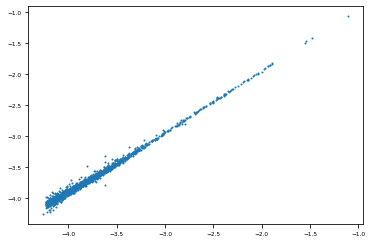

In [54]:
plt.scatter(np.log10(x_param[0]), np.log10(m), s=1)